In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import seaborn as sns
import random
from PIL import Image
import cv2
from matplotlib import rcParams
import re

In [2]:
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [3]:
main_folder = '../input/archie-comics-multi-class/Multi-class'

In [4]:
samples_per_class = []
classes = []
file_names = []

In [5]:
directory=os.listdir('../input/archie-comics-multi-class/Multi-class/')
for each in directory:
    currentFolder = '../input/archie-comics-multi-class/Multi-class/' + each
    count = sum(len(files) for _, _, files in os.walk(currentFolder))
    samples_per_class.append(count)
    classes.append(each)
    
    for i, file in enumerate(os.listdir(currentFolder)):
        fullpath = currentFolder+ "/" + file
        file_names.append(fullpath)

In [6]:
min(samples_per_class)

33

In [7]:
small_ds = []

In [8]:
for each_class in classes:
    trial_list = []
    for name in file_names:
        if re.search(f'{each_class}', name):
            trial_list.append(name)
    small_ds.append(random.sample(trial_list, min(len(trial_list),200)))

In [9]:
print(len(small_ds))
print(len(small_ds[0]))
print(len(small_ds)*len(small_ds[0]))

23
41
943


In [10]:
small_ds=list(np.concatenate(small_ds).flat)
# For flattening small_ds into a 1-D list

In [11]:
print(len(small_ds))

2807


In [12]:
classes

['Kleats',
 'Midge',
 'Dilton',
 'Pop Tate',
 'Reggie',
 'Jughead',
 'Grundy',
 'Ethel',
 'Weatherbee',
 'Harry Clayton',
 'Smithers',
 'Svenson',
 'Moose',
 'Chuck',
 'Nancy',
 'Veronica',
 'Flutesnoot',
 'Fred Andrews',
 'Archie',
 'Betty',
 'Beazley',
 'Hiram Lodge',
 'Others']

In [13]:
small_ds[720:730]

['../input/archie-comics-multi-class/Multi-class/Jughead/Jughead_772.png',
 '../input/archie-comics-multi-class/Multi-class/Jughead/Jughead_319.png',
 '../input/archie-comics-multi-class/Multi-class/Jughead/Jughead_449.png',
 '../input/archie-comics-multi-class/Multi-class/Jughead/Jughead_404.png',
 '../input/archie-comics-multi-class/Multi-class/Jughead/Jughead_199.png',
 '../input/archie-comics-multi-class/Multi-class/Jughead/Jughead_278.png',
 '../input/archie-comics-multi-class/Multi-class/Jughead/Jughead_520.png',
 '../input/archie-comics-multi-class/Multi-class/Jughead/Jughead_080.png',
 '../input/archie-comics-multi-class/Multi-class/Jughead/Jughead_870.png',
 '../input/archie-comics-multi-class/Multi-class/Jughead/Jughead_591.png']

In [14]:
files_df = pd.DataFrame(index=range(0, len(small_ds)),columns = ['Files'])

In [15]:
files_df['Files'] = small_ds

In [16]:
files_df['Class'] = files_df.Files.str.extract(r'Multi-class/(.*?)/', expand=True)

In [17]:
files_df.head()

,Files,Class
0,../input/archie-comics-multi-class/Multi-class...,Kleats
1,../input/archie-comics-multi-class/Multi-class...,Kleats
2,../input/archie-comics-multi-class/Multi-class...,Kleats
3,../input/archie-comics-multi-class/Multi-class...,Kleats
4,../input/archie-comics-multi-class/Multi-class...,Kleats


In [18]:
files_df = files_df.sample(frac=1, random_state=1).reset_index(drop=True)
# For randomly shuffling the rows of the dataframe,
# else the training set gets the the top classes, the validation the bottom classes of the df
# random_state is for reproducability, i.e., same distribution each time the code is run

In [19]:
pd.set_option('display.max_colwidth', None)

In [20]:
files_df.tail(10)

,Files,Class
2797,../input/archie-comics-multi-class/Multi-class/Hiram Lodge/Hiram Lodge_018.png,Hiram Lodge
2798,../input/archie-comics-multi-class/Multi-class/Others/Others_128.png,Others
2799,../input/archie-comics-multi-class/Multi-class/Dilton/Dilton_114.png,Dilton
2800,../input/archie-comics-multi-class/Multi-class/Dilton/Dilton_133.png,Dilton
2801,../input/archie-comics-multi-class/Multi-class/Ethel/Ethel_031.png,Ethel
2802,../input/archie-comics-multi-class/Multi-class/Others/Others_124.png,Others
2803,../input/archie-comics-multi-class/Multi-class/Ethel/Ethel_057.png,Ethel
2804,../input/archie-comics-multi-class/Multi-class/Weatherbee/Weatherbee_150.png,Weatherbee
2805,../input/archie-comics-multi-class/Multi-class/Dilton/Dilton_026.png,Dilton
2806,../input/archie-comics-multi-class/Multi-class/Weatherbee/Weatherbee_229.png,Weatherbee


In [21]:
datagen=ImageDataGenerator(validation_split=0.2)

In [22]:
batch_size = 8

In [23]:
train_generator=datagen.flow_from_dataframe(
dataframe=files_df,
directory=None,
x_col='Files',
y_col='Class',
subset="training",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
rotation_range=30,
width_shift_range=0.2,
height_shift_range=0.2,
brightness_range=(0.5,1.5),
shear_range=0.2,
zoom_range=0.2,
channel_shift_range=30.0,
fill_mode='nearest',
horizontal_flip=True,
vertical_flip=False,
target_size=(256,256))

valid_generator=datagen.flow_from_dataframe(
dataframe=files_df,
directory=None,
x_col='Files',
y_col='Class',
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

Found 2246 validated image filenames belonging to 23 classes.
Found 561 validated image filenames belonging to 23 classes.


In [24]:
stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        min_delta=0,
        patience=15,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
    )

checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "best_model",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    )

In [25]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', input_shape=(256, 256, 3), classes=len(classes), include_top = False)


# Based on https://pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/

# construct the head of the model that will be placed on top of the
# the base model
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(classes), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=base_model.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(),#from_logits=True),
        metrics=["accuracy"]
    )
 
loss_0, acc_0 = model.evaluate(valid_generator)
print(f"loss {loss_0}, acc {acc_0}")
    

history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=50,
        callbacks=[stopping, checkpoint]
)

model.load_weights("best_model")

loss, acc = model.evaluate(valid_generator)
print(f"final loss {loss}, final acc {acc}")

2022-06-28 21:46:30.834932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 21:46:30.952914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 21:46:30.953790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 21:46:30.955839: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


2022-06-28 21:46:36.229413: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-28 21:46:38.936380: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


71/71 [==============================] - 16s 104ms/step - loss: 3.9879 - accuracy: 0.0392
loss 3.9879391193389893, acc 0.03921568766236305
Epoch 1/50
281/281 [==============================] - 35s 115ms/step - loss: 3.2658 - accuracy: 0.0864 - val_loss: 2.8276 - val_accuracy: 0.1818
Epoch 2/50
281/281 [==============================] - 15s 55ms/step - loss: 2.8501 - accuracy: 0.1487 - val_loss: 2.6901 - val_accuracy: 0.2175
Epoch 3/50
281/281 [==============================] - 15s 52ms/step - loss: 2.6513 - accuracy: 0.2066 - val_loss: 2.5419 - val_accuracy: 0.2656
Epoch 4/50
281/281 [==============================] - 15s 54ms/step - loss: 2.5260 - accuracy: 0.2418 - val_loss: 2.4637 - val_accuracy: 0.2692
Epoch 5/50
281/281 [==============================] - 15s 52ms/step - loss: 2.3221 - accuracy: 0.2916 - val_loss: 2.3666 - val_accuracy: 0.3030
Epoch 6/50
281/281 [==============================] - 15s 54ms/step - loss: 2.1747 - accuracy: 0.3384 - val_loss: 2.3028 - val_accuracy: 0.3

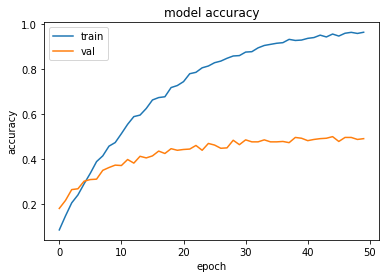

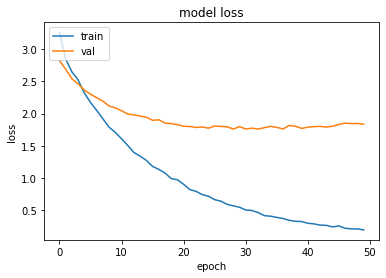

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
index_classes_dict = {k: v for v, k in enumerate(classes)}

In [28]:
index_classes_list = list(index_classes_dict.values())

In [29]:
inv_index_classes_dict = {v: k for k, v in index_classes_dict.items()}

In [30]:
inv_index_classes_list = list(inv_index_classes_dict.values())

In [31]:
y_pred = []  # store predicted labels
y_true = []  # store true labels
i = 0
# iterate over the dataset
for image_batch, label_batch in valid_generator:
    # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))
    i+=1
    if i == len(valid_generator): # A generator runs infinitely, 
        # so here I am running the valid gen once so all samples are seen
        # The gen length is valid split * total samples / batch size
        # 0.2*759/8 = 19
        break


# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels,axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [32]:
names_correct_labels = np.vectorize(inv_index_classes_dict.get)(correct_labels)
names_predicted_labels = np.vectorize(inv_index_classes_dict.get)(predicted_labels)

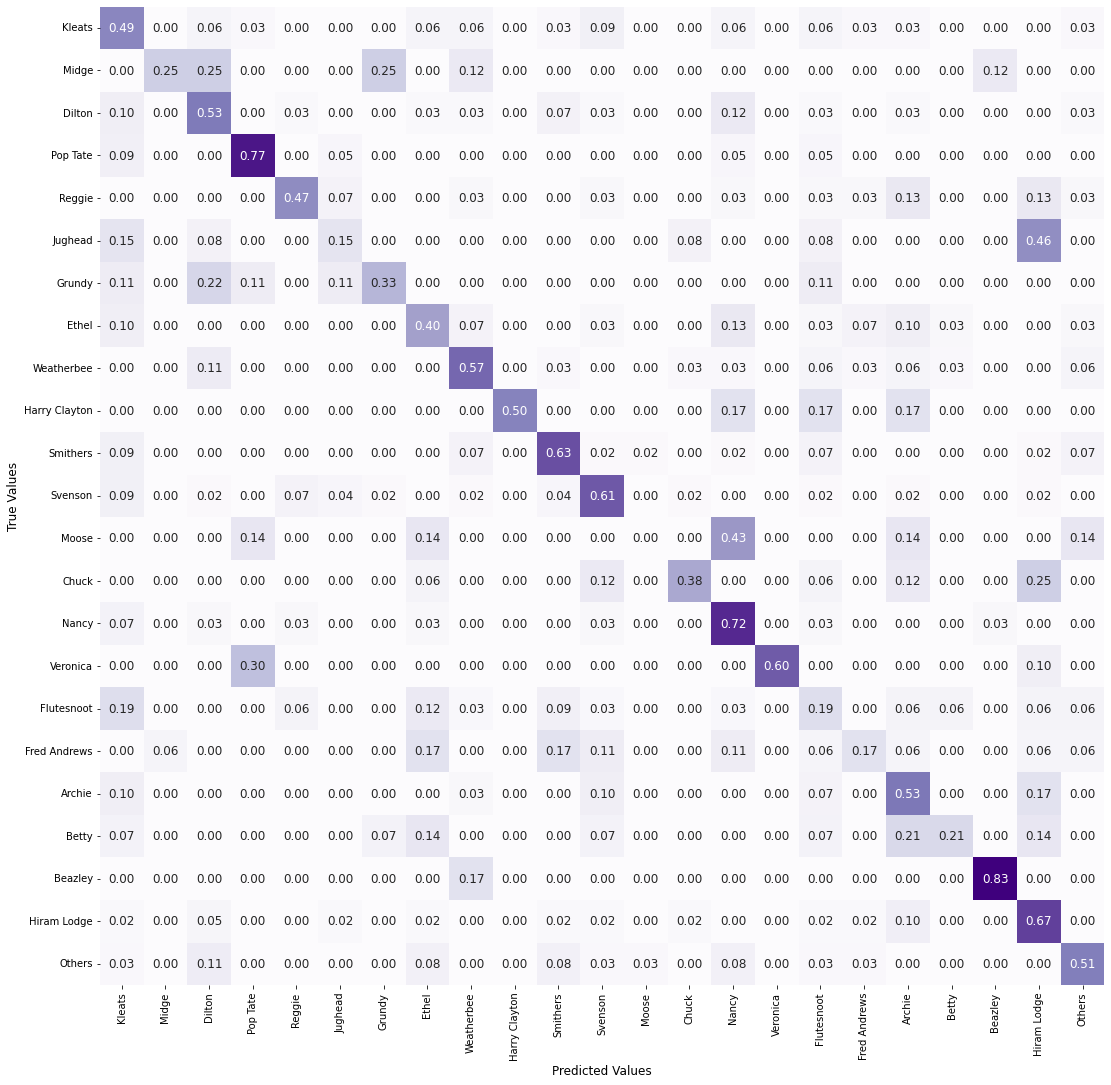

In [33]:
cm = confusion_matrix(correct_labels, predicted_labels, labels=index_classes_list, normalize='true')
fig = plt.figure(figsize = (18,18))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.2) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples', fmt='.2f', 
            xticklabels=inv_index_classes_list, yticklabels=inv_index_classes_list);
ax1.set_ylabel('True Values',fontsize=12)
ax1.set_xlabel('Predicted Values',fontsize=12)
plt.show()

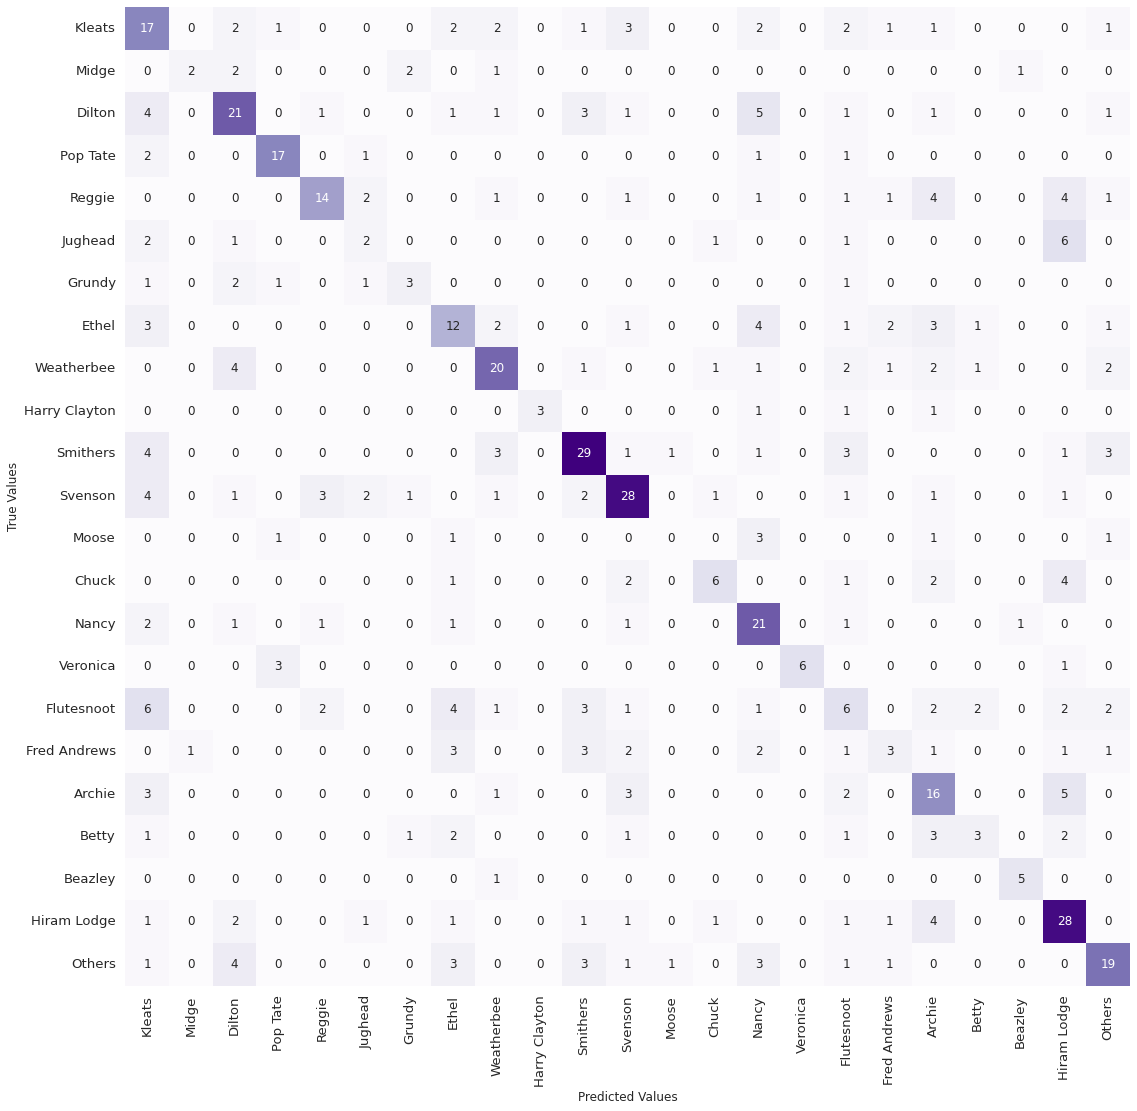

In [34]:
cm = confusion_matrix(correct_labels, predicted_labels, labels=index_classes_list)
fig = plt.figure(figsize = (18,18))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.2) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples', fmt='d',
           xticklabels=inv_index_classes_list, yticklabels=inv_index_classes_list);
ax1.set_ylabel('True Values',fontsize=12)
ax1.set_xlabel('Predicted Values',fontsize=12)
plt.show()